# Modeling #
It's time to model the hockey data and predict playoff performances. I'm using the same kernel as the hockey_features notebook so variables are shared.

In [231]:
import pandas as pd
import time
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from numpy import arange
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures

### Train and Test Split ###
It is important to split the data by season, so that the classification report makes sense later on. Since the number of seasons is rather small, the random split is quite influential. I'll have to try a number of random seeds to optimize the model.

In [33]:
def create_split(X, y, random_seed):
    ''' (DataFrame, DataFrame, list, int) -> DataFrame, DataFrame, DataFrame, DataFrame
    Returns a random split of X and y along seasons from the model_seasons list. Split is 75% train, 25% test.
    '''
    model_seasons = X['Season'].unique()
    
    # Seed the RNG
    random.seed(random_seed)
    random.shuffle(model_seasons)
    
    # Split the list into two lists
    train_seasons = model_seasons[:int(len(model_seasons) * .75)]
    test_seasons = model_seasons[int(len(model_seasons) * .75):]

    # Create the train-test split
    X_train = X.loc[X['Season'].isin(train_seasons)].set_index(['Team', 'Season'])
    X_test = X.loc[X['Season'].isin(test_seasons)].set_index(['Team', 'Season'])

    y_train = y.loc[y['Season'].isin(train_seasons)].set_index(['Team', 'Season'])
    y_test = y.loc[y['Season'].isin(test_seasons)].set_index(['Team', 'Season'])

    return X_train, X_test, y_train, y_test

### Evaluation ###
To properly evaluate the predictions, I must convert the points percentages to playoff seedings. Then I can compare the true playoff standings from those seasons to the predictions and score the predictions

In [34]:
def evaluate_model(X_test, y_test, model):
    ''' (DataFrame, DataFrame, model) -> confusion matrix, classification report
    Returns confusion matrix and classification report for trained model.
    '''
    # Make prediction
    pts_pred = model.predict(X_test)

    # Combine prediction and actual values
    y_score = y_test.drop('PTS%', axis = 1)
    y_score['PTS%_Pred'] = pts_pred

    # Convert predicted points percentage to playoff status
    playoff_preds = create_playoff_preds(y_score, answer_key)

    # Assign boolean columns
    y_true = playoff_preds['True_playoffs'].astype(int)
    y_pred = playoff_preds['Pred_playoffs'].astype(int)
    
    # Generate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names = ['Playoffs', 'Non-Playoffs'], output_dict = True)
    
    return conf_matrix, report

## OLS Linear Model ##
An ordinary least squares linear regression is a sensible first model to try in a situation like this. It's simple but should capture the general trend of the data reasonably well.

In [35]:
# Splitting the train and test data using an arbitrary seed
X_train, X_test, y_train, y_test = create_split(X, y, 2)

model = LinearRegression()
# Fit the model to the training data
model.fit(X_train, y_train);

# Accuracy of the model when predicting on the test data
conf_matrix, report = evaluate_model(X_test, y_test, model)
score = report['accuracy']
print(f'Model accuracy on test data: {score*100:.2f}%')

# Accuracy of the model when predicting on the holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, model)
score = report['accuracy']
print(f'Model accuracy on holdout 2023 data: {score*100:.2f}%')
print(conf_matrix)

Model accuracy on test data: 70.73%
Model accuracy on holdout 2023 data: 68.75%
[[11  5]
 [ 5 11]]


So this model, which was trained on the random split from seed 2, correctly classified 11 of 16 playoff teams. After a handful of trials, it's clear that the hurdle for this linear model to clear is the 10/16 or 62.5% mark. Most iterations end up stuck on that ratio regardless of the test set accuracy. Seed 2 is actually a bit of an outlier in that regard.

In [36]:
seed_2_train_seasons = X_train.reset_index(drop = False)['Season'].unique()
seed_2_test_seasons = X_test.reset_index(drop = False)['Season'].unique()
print(f'The model was trained on data from {seed_2_train_seasons}\n \
It was tested on data from {seed_2_test_seasons}')

The model was trained on data from [2007 2009 2010 2011 2013 2014 2015 2016 2017 2018 2019 2020]
 It was tested on data from [2008 2012 2021 2022]


This split of the training and testing data resulted in better performance than most models, but it excluded the 2 most recent seasons from the training set. Perhaps there were anomalous performances in those seasons that skewed the model's behavior. 

### OLS Linear Model Optimization ###
After a couple trials, it's clear that the random seed influences the accuracy of the model quite a bit. This is to be expected since the training dataset isn't tremendously large, accounting for just 12 seasons. Maybe trying a variety of random seeds will yield a model that's trained on a range of data that better encapsulates the overall trend. I can check out this model's performance on the holdout data and check out the train-test split with the specific seed.

In [37]:
def optimize_linear_model(X, y):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None

    # Pick 100 random seeds (in reality there are 43,680 possible combinations of train-test splits)
    # At 0.16 seconds per model, it would take nearly 2 hours to check them all
    seed_list = [random.randint(0, 1000) for _ in range(100)]

    for random_seed in seed_list:
        # Create a new split and model for each seed
        X_train, X_test, y_train, y_test = create_split(X, y, random_seed)
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Evaluate the model
        conf_matrix, report = evaluate_model(X_test, y_test, model)
        score = report['accuracy']

        # Conditionally update the best model parameters
        if score > hi_score:
            hi_score = score
            best_model = model
            seed = random_seed

    return best_model, hi_score, seed

### A Note About Comments ###
After finding the optimal model from the optimization function, I'll comment out the code so it doesn't run every time I restart the kernel. I've preserved the code output from the optimization function in a markdown cell below each function call.

In [102]:
# Running and timing the optimization function
'''
start = time.time()
best_model, hi_score, seed = optimize_linear_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
''';

Code output: \
Execution time: 00:17 \
The best seed was 625 with 83.74% test data accuracy.

In [116]:
# Building best model
best_model = LinearRegression()
X_train, X_test, y_train, y_test = create_split(X, y, 756)
best_model.fit(X_train, y_train)
#Running and evaluating the best model on the holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_model)
print(conf_matrix)
print(report['accuracy'])

[[10  6]
 [ 6 10]]
0.625


Once again, in spite of a better test set accuracy, the best model isn't generalizing to the 2023 data well. This isn't a huge surprise but I'm confident I can find improvements by tweaking the model, performing PCA, and trying other types of models.

### Cheating to find the best seed ###

Out of curiosity, I want to see the best result possible from just shuffling seeds, so I'm going to use the accuracy when predicting the holdout data as the target metric.

In [41]:
def cheat_linear_model(X, y, X_hold, y_hold):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None

    # Pick 100 random seeds (in reality there are 43,680 possible combinations of train-test splits)
    # At 0.16 seconds per model, it would take nearly 2 hours to check them all
    seed_list = [random.randint(0, 1000) for _ in range(500)]

    for random_seed in seed_list:
        # Create a new split and model for each seed
        X_train, X_test, y_train, y_test = create_split(X, y, random_seed)
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Evaluate the model
        conf_matrix, report = evaluate_model(X_hold, y_hold, model)
        score = report['accuracy']

        # Conditionally update the best model parameters
        if score > hi_score:
            hi_score = score
            best_model = model
            seed = random_seed

    return best_model, hi_score, seed

In [103]:
# Running and timing the optimization function
'''
start = time.time()
best_model, hi_score, seed = cheat_linear_model(X, y, X_hold, y_hold)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
''';

Code output: \
Execution time: 00:25. \
The best seed was 903 with 68.75% test data accuracy.

This is a bit of a surprise. Even searching 500 seeds, I can't find a train-test split that beats 11/16 or 68.75% accuracy. Evidently, this linear approach just doesn't predict well for the 2023 data. I'm still confident I can get a better result from other approaches that aren't so linear, but I also want to check out PCA.

### OLS with PCA ###
Reducing the dimensionality of the data may help my linear model perform better on the data, so I'll try that approach.

In [43]:
def create_PCA(X, X_hold, n_components):

    X_pre_pca = X.set_index(['Team', 'Season'])
    column_names = X_pre_pca.columns
    X_index_names = X_pre_pca.index
    hold_index_names = X_hold.index
    pca = PCA(n_components = n_components)

    # The training and testing data need to have the index reset for the process of splitting by season.
    # It will be set again later
    X_pca = pd.DataFrame(pca.fit_transform(X_pre_pca),
                         columns = [f'PC{i}' for i in range(1, n_components+1)],
                         index = X_index_names).reset_index(drop = False)

    # The holdout data do not need the index to be reset
    X_hold_pca = pd.DataFrame(pca.transform(X_hold),
                              columns = [f'PC{i}' for i in range(1, n_components+1)],
                              index = hold_index_names)

    return X_pca, X_hold_pca, pca

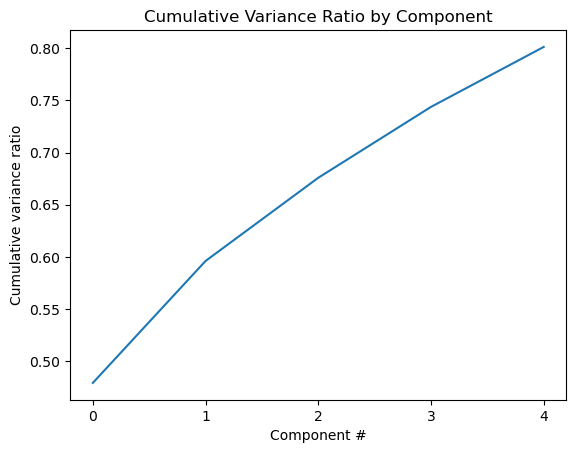

In [44]:
# Performing the PCA with 5 components
X_pca, X_hold_pca, pca = create_PCA(X, X_hold, 5) 
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.xticks(np.arange(0, 5))
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative Variance Ratio by Component')
plt.show()

I can explain about 80% of the variance in the data with 5 components. It's worth a shot to try modeling and evaluating on the transformed data.

In [104]:
# Running and timing the optimization function
'''
start = time.time()
best_model, hi_score, seed = optimize_linear_model(X_pca, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
''';

Code output: \
Execution time: 00:15. \
The best seed was 951 with 80.33% test data accuracy.

In [117]:
# Building best model
best_model = LinearRegression()
X_train, X_test, y_train, y_test = create_split(X_pca, y, 951)
best_model.fit(X_train, y_train)
#Running and evaluating the best model on the holdout data
conf_matrix, report = evaluate_model(X_hold_pca, y_hold, best_model)
print(conf_matrix)
print(report['accuracy'])

[[10  6]
 [ 6 10]]
0.625


The best model from the PCA data scored over 80% accuracy on the testing data. Unsurprisingly, it achieved the same 62.5% accuracy on the holdout data. So in this case, PCA didn't help. Maybe it will be useful for a different type of model later on.

### OLS with all data ###
Now that it's well established that the linear model is overfitting regardless of the split, I'll evaluate its predictive performance when training on all the data and predicting on the holdout data.

In [48]:
model = LinearRegression()
model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))

conf_matrix, report = evaluate_model(X_hold, y_hold, model)
print(conf_matrix)
print(report['accuracy'])

[[10  6]
 [ 6 10]]
0.625


To absolutely no surprise, it got 10 out of 16 right again.

## Elastic Net Regression ##
It's time to seek some improvement over the OLS linear model by adding some penalty terms.

In [49]:
def optimize_elastic_model(X, y):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None
    best_l1 = None
    best_alpha = None

    # Pick random seeds
    seed_list = [random.randint(0, 1000) for _ in range(10)]
    # Pick alpha term
    alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0]
    # Pick l1 ratio
    l1_list = arange(0, .5, 0.025)
    
    for random_seed in seed_list:
        for alpha in alpha_list:
            for l1 in l1_list:
            # Create a new split and model for each seed
                X_train, X_test, y_train, y_test = create_split(X, y, random_seed)
                # Train a new model on the split with the alpha and l1 parameters
                model = ElasticNet(random_state = 14, alpha = alpha, l1_ratio = l1)
                model.fit(X_train, y_train)
    
            # Evaluate the model
                conf_matrix, report = evaluate_model(X_test, y_test, model)
                score = report['accuracy']
    
            # Conditionally update the best model parameters
                if score > hi_score:
                    hi_score = score
                    best_model = model
                    seed = random_seed
                    best_alpha = alpha
                    best_l1 = l1

    return best_model, hi_score, seed, best_alpha, best_l1

In [95]:
# Running and timing the optimization function
'''
start = time.time()
best_EN_model, hi_score, seed, alpha, l1 = optimize_elastic_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
print(f'The best alpha was {alpha} and the best l1 ratio was {l1}.')
''';

Code output: \
Execution time: 03:23 \
The best seed was 426 with 75.81% test data accuracy. \
The best alpha was 0.1 and the best l1 ratio was 0.025.

In [119]:
# Build optimal model from grid search
best_EN_model = ElasticNet(random_state = 14, alpha = 0.1, l1_ratio = 0.25)
X_train, X_test, y_train, y_test = create_split(X, y, 426)
best_EN_model.fit(X_train, y_train)
# Evaluate optimal model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_EN_model)
print(conf_matrix)
print(report['accuracy'])

[[10  6]
 [ 6 10]]
0.625


After running a number of trials with varying alpha and l1 ratio ranges, I haven't seen any performance improvements over the standard linear model.

## Random Forest Regression ##
Random Forest Regression may be able to capture the interactions between all the features better than a linear model.

In [87]:
def optimize_RFR_model(X, y):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None
    best_criterion = None
    best_n_est = None
    best_depth = None
    

    # Choose seed 357 since it performed best in larger grid searches
    seed_list = [357] #[random.randint(0, 1000) for _ in range(10)]
    # Pick error criterion, eliminated Poisson since it was never optimal
    criteria = ['squared_error', 'friedman_mse']
    # Pick number of estimators
    n_est_list = arange(100, 200, 25)
    # Pick max depth, elimiated lower ranges since best models were around 10 nodes deep
    depths = [10, 12, 15]
    
    for random_seed in seed_list:
        for criterion in criteria:
            for n_est in n_est_list:
                for depth in depths:
                # Create a new split and model for each seed
                    X_train, X_test, y_train, y_test = create_split(X, y, random_seed)
                    # Train a new model on the split
                    model = RandomForestRegressor(random_state = 14, criterion = criterion, n_estimators = n_est, max_depth = depth)
                    model.fit(X_train, y_train)
        
                # Evaluate the model
                    conf_matrix, report = evaluate_model(X_test, y_test, model)
                    score = report['accuracy']
        
                # Conditionally update the best model parameters
                    if score > hi_score:
                        hi_score = score
                        best_model = model
                        seed = random_seed
                        best_n_est = n_est
                        best_depth = depth
                        best_criterion = criterion

    return best_model, hi_score, seed, best_n_est, best_depth, best_criterion

In [91]:
# Running and timing the optimization function
'''
start = time.time()
best_RFR_model, hi_score, seed, best_n_est, best_depth, best_criterion = optimize_RFR_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
print(f'The best criterion was {best_criterion}, the ideal max depth was {best_depth}, and the best number of estimators was {best_n_est}.')
''';

Code output:\
Execution time: 00:10.\
The best seed was 357 with 73.98% test data  accuracy \.\
The best criterion was squared_error, the ideal max depth was 10, and the best number of estimators was 150.0.0.

In [118]:
# Building best model from grid search
best_RFR_model = RandomForestRegressor(criterion = 'squared_error', max_depth = 10, n_estimators = 150, random_state = 14)
X_train, X_test, y_train, y_test = create_split(X, y, 357)
best_RFR_model.fit(X_train, y_train)
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_RFR_model)
print(conf_matrix)
print(report['accuracy'])

[[12  4]
 [ 4 12]]
0.75


Finally! A model has successfully predicted at least 75% of playoff teams for the holdout data. This was the target threshold for the project. Now, I want to explore some other models in order to see if any of them perform just as well or better on the holdout data and improve the test data performance as well.

## Support Vector Regression ##
Support Vector Machine Classifiers find hyperplanes that separate classes. A SVR does something similar with a hyperplane of best fit. I don't know what to expect from it in terms of performance on this dataset. 

In [158]:
def optimize_SVR_model(X, y):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None
    best_kernel = None
    best_gamma = None
    best_degree = None
    

    # Pick random seeds
    seed_list = [random.randint(0, 1000) for _ in range(10)]
    # Pick kernel, opting away from linear
    kernel_list = ['poly', 'rbf', 'sigmoid']
    # Pick number of estimators
    gamma_list = ['scale', 'auto']
    # Pick degrees for poly kernel
    degrees = [2, 3, 4]
    
    for random_seed in seed_list:
        for kernel in kernel_list:
            for gamma in gamma_list:
                for degree in degrees:
                    # Create a new split and model for each seed
                    X_train, X_test, y_train, y_test = create_split(X, y, random_seed)
                    # Train a new model on the split
                    model = SVR(gamma = gamma, kernel = kernel, degree = degree, epsilon = 0.05)
                    model.fit(X_train, y_train)
            
                    # Evaluate the model
                    conf_matrix, report = evaluate_model(X_test, y_test, model)
                    score = report['accuracy']
            
                    # Conditionally update the best model parameters
                    if score > hi_score:
                        hi_score = score
                        best_model = model
                        seed = random_seed
                        best_gamma = gamma
                        best_kernel = kernel
                        best_degree = degree

    return best_model, hi_score, seed, best_gamma, best_kernel, best_degree

In [161]:
# Running and timing the optimization function
'''
start = time.time()
best_SVR_model, hi_score, seed, best_gamma, best_kernel, best_degree = optimize_SVR_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
print(f'The best gamma was {best_gamma} and the ideal kernel was {best_kernel}.')
''';

Code output: \
Execution time: 00:22. \
The best seed was 245 with 75.41% test data accuracy. \
The best gamma was scale and the ideal kernel was rbf.

In [160]:
# Building the optimal model
best_SVR_model = SVR(gamma = 'scale', kernel = 'rbf', epsilon = 0.05)
X_train, X_test, y_train, y_test = create_split(X, y, 245)
best_SVR_model.fit(X_train, y_train)
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_SVR_model)
print(conf_matrix)
print(report['accuracy'])

[[13  3]
 [ 3 13]]
0.8125


The Support Vector Regressor achieved the highest accuracy so far, with 13 out of 16 correct picks. I'm curious to know how many of those picks are in common with the Random Forest Regressor. I'll compare all the picks after evaluating the rest of the model types.

## LightGBM Regression ##
LGBM Regression isn't terribly different from Random Forest Regression, but it has more parameters to tune and can achieve better performance, depending on the data and parameters.

In [217]:
def optimize_GBM_model(X, y):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None
    best_boost = None
    best_leaves = None
    best_depth = None

    # Pick random seeds
    seed_list = [random.randint(0, 1000) for _ in range(25)]
    # Pick boosting type
    boost_list = ['gbdt', 'dart']
    # Pick number of leaves
    leaf_list = [3, 5, 7]
    # Set max depth
    depth_list = [3, 5, 7]
    
    for random_seed in seed_list:
        for boost in boost_list:
            for leaf in leaf_list:
                for depth in depth_list:
                    # Create a new split and model for each seed
                    X_train, X_test, y_train, y_test = create_split(X, y, random_seed)
                    # Train a new model on the split
                    model = LGBMRegressor(random_state = 14, num_leaves = leaf, max_depth = depth, boosting_type = boost, min_data_in_leaf = 15, verbosity = -1, force_col_wise = True)
                    model.fit(X_train, y_train)
            
                    # Evaluate the model
                    conf_matrix, report = evaluate_model(X_test, y_test, model)
                    score = report['accuracy']
            
                    # Conditionally update the best model parameters
                    if score > hi_score:
                        hi_score = score
                        best_model = model
                        seed = random_seed
                        best_boost = boost
                        best_depth = depth
                        best_leaves = leaf

    return best_model, hi_score, seed, best_boost, best_depth, best_leaves

In [233]:
'''
start = time.time()
best_GBM_model, hi_score, seed, best_boost, best_depth, best_leaves = optimize_GBM_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
print(f'The best boost was {best_boost}, the best number of leaves was {best_leaves}, and the ideal depth was {best_depth}.')
''';

Code output: \
Execution time: 01:15 \
The best seed was 20 with 83.74% test data accuracy. \
The best boost was dart, the best number of leaves was 7, and the ideal depth was 5.

In [229]:
# Building the optimal model
best_GBM_model = LGBMRegressor(boosting_type = 'dart', num_leaves = 7, max_depth = 5, random_state = 14, min_data_in_leaf = 15, verbosity = -1, force_col_wise = True)
X_train, X_test, y_train, y_test = create_split(X, y, 20)
best_GBM_model.fit(X_train, y_train)
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_GBM_model)
print(conf_matrix)
print(report['accuracy'])

[[12  4]
 [ 4 12]]
0.75


The LightGBM Regressor model has also hit the 75% accuracy threshold. I'll try a couple more types of model to see if it's possible to consistently improve on this number.

## Polynomial Regression ##
Trying a variety of polynomial curves might fit better than linear models did earlier.

In [237]:
# Optimizing the polynomial model
def optimize_poly_model(X, y):
    ''' (DataFrame, DataFrame) -> model, float, int
    Returns the best performing linear regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''
    hi_score = 0
    best_model = None
    seed = None
    best_degree = None

    # Pick random seeds
    seed_list = [random.randint(0, 1000) for _ in range(25)]
    # Pick polynomial degree
    degrees = [2, 3, 4, 5, 6, 7]
    
    for random_seed in seed_list:
        for degree in degrees:
            # Create a new split and model for each seed
            X_train, X_test, y_train, y_test = create_split(X, y, random_seed)

            # Fit each model
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
    
            # Evaluate the model
            conf_matrix, report = evaluate_model(X_test_poly, y_test, model)
            score = report['accuracy']
    
            # Conditionally update the best model parameters
            if score > hi_score:
                hi_score = score
                best_model = model
                seed = random_seed
                best_degree = degree

    return best_model, hi_score, seed, best_degree

In [240]:
'''
start = time.time()
best_poly_model, hi_score, seed, degree = optimize_poly_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))
print(f'The best seed was {seed} with {hi_score*100:.2f}% test data accuracy.')
print(f'The best degree was {best_degree}.')
''';

Code output: \
Execution time: 01:13 \
The best seed was 239 with 75.81% test data accuracy. \
The best degree was 2.

In [239]:
# Building the optimal model
poly = PolynomialFeatures(degree=2)
X_train, X_test, y_train, y_test = create_split(X, y, 239)
X_train_poly = poly.fit_transform(X_train)
X_hold_poly = poly.transform(X_hold)
model = LinearRegression()
model.fit(X_train_poly, y_train)
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold_poly, y_hold, model)
print(conf_matrix)
print(report['accuracy'])

[[13  3]
 [ 3 13]]
0.8125


While the 2nd degree polynomial didn't overfit the test data, it performed as well as anything I've seen so far on the holdout data. This is a somewhat surprising development.

## Next Steps ##
* Try Bayesian regression
* Take an ensemble approach using some or all of the above
* Visualize models (train, test, holdout data and fit curves)